**BETTER MJO CODE**

This is very similar to the other MJO notebook, but averages across the entire time range rather than just using the first 90 days. As can be seen, this produces much more well-defined results (although still not an obvious match for the actual MJO). For a more thoroughly-commented version of virtually the same code, see the other MJO notebook.

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sklearn.cluster
import scipy.cluster
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler

In [4]:
ds = xr.open_dataset('/Users/bennysmith/Documents/DATA_1150/Project_datasets/olr.day.mean.nc')

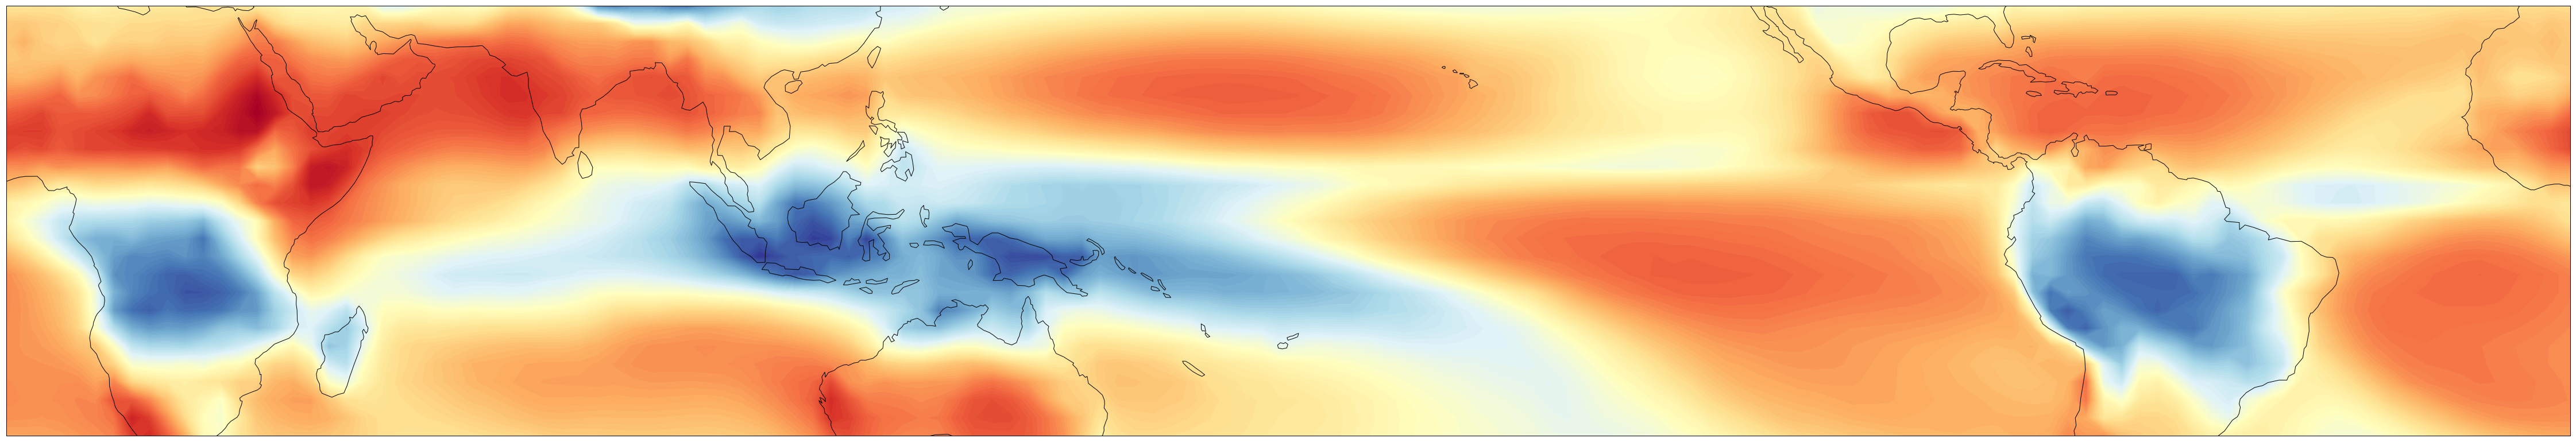

In [5]:
lower_lat_index = list(ds.lat.values).index(30)
upper_lat_index = list(ds.lat.values).index(-30)+1

# lower_lon_index = list(ds.lon.values).index(20)
# upper_lon_index = list(ds.lon.values).index(240)+1

olr = ds.olr.isel(lat=slice(lower_lat_index, upper_lat_index)) # Choosing latitudes 20-80N
# olr=olr.isel(time=slice(0, 100))
olr = olr.interpolate_na(dim='time', method='linear')
# olr = olr.isel(lon=slice(lower_lon_index, upper_lon_index))

lat = ds.lat.isel(lat=slice(lower_lat_index,upper_lat_index)) # Defining a latitude variable
# lon = ds.lon.isel(lon=slice(lower_lon_index,upper_lon_index)) # Defining a latitude variable
lon = ds.lon


def is_djf(month): # source: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
  return (month>=12) | ((month>=1) & (month<=2)) # The | symbol is an OR operator
olr = olr.sel(time=is_djf(olr['time.month']))


olrvals = olr.values
olrmean = np.nanmean(olrvals, axis=0)

mins = []
maxes = []
fig = plt.figure(figsize=(20*4,5*4))
for i in olrmean:
  mins.append(min(i))
  maxes.append(max(i))
levels = np.linspace(min(mins), max(maxes), 100)
ax = plt.axes(projection=ccrs.LambertCylindrical(central_longitude=180))
cs=ax.contourf(lon, lat, olrmean[:, :],levels,
              transform=ccrs.LambertCylindrical(),
              cmap=plt.cm.RdYlBu_r)
ax.coastlines()
# ax.set_extent([-160, 60, -15, 15], crs=ccrs.LambertCylindrical(central_longitude=180)) # longitude latitude extent



# ax.set_extent([lower_lon_index, upper_lon_index, lower_lat_index, upper_lat_index]) # longitude latitude extent
# plt.colorbar(cs, orientation='vertical') # color map
plt.show()

In [6]:
olranomalies = olrvals - olrmean
olrvals = olranomalies
# olrvals = olrvals[::4, :, :]
olrvals = olrvals.reshape(len(olrvals[:, 0, 0]), len(lat)*len(lon))
number_clusters = 4
kmeans_model = sklearn.cluster.KMeans(n_clusters=number_clusters, random_state=10).fit(olrvals)
mjo_clusters = kmeans_model.fit_predict(olrvals)
all_clusters = {}
for i in range(number_clusters):
  cluster_indices = np.argwhere(mjo_clusters == i)[:,0]
  cluster_composite = np.mean(olrvals[cluster_indices], axis=0).reshape(len(lat), len(lon))
  all_clusters['cluster'+str(i+1)+'_composite'] = cluster_composite

In [7]:
olr = ds.olr.isel(lat=slice(lower_lat_index, upper_lat_index)) # Choosing latitudes 20-80N
print(type(olr))
olr = olr.interpolate_na(dim='time', method='linear')
print(type(olr))

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


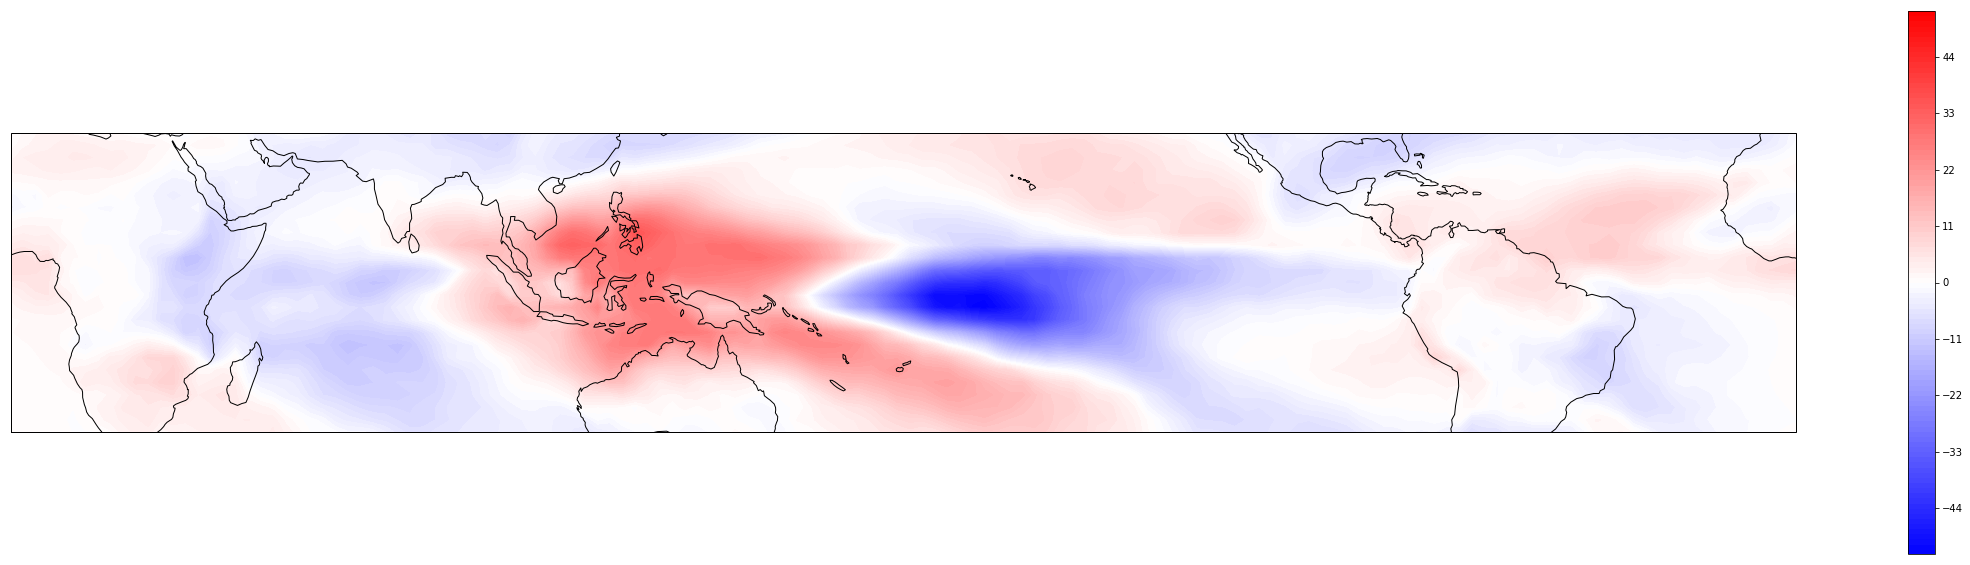

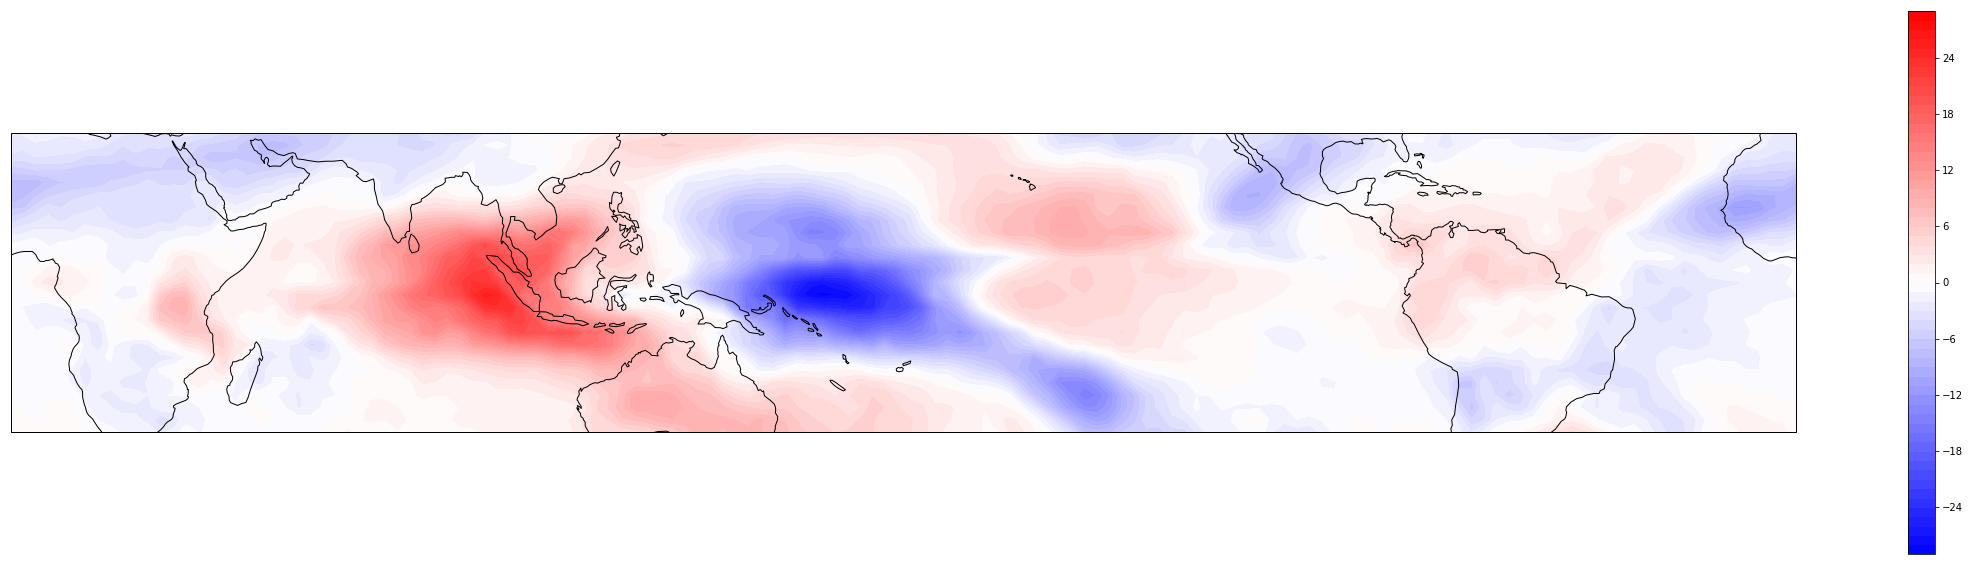

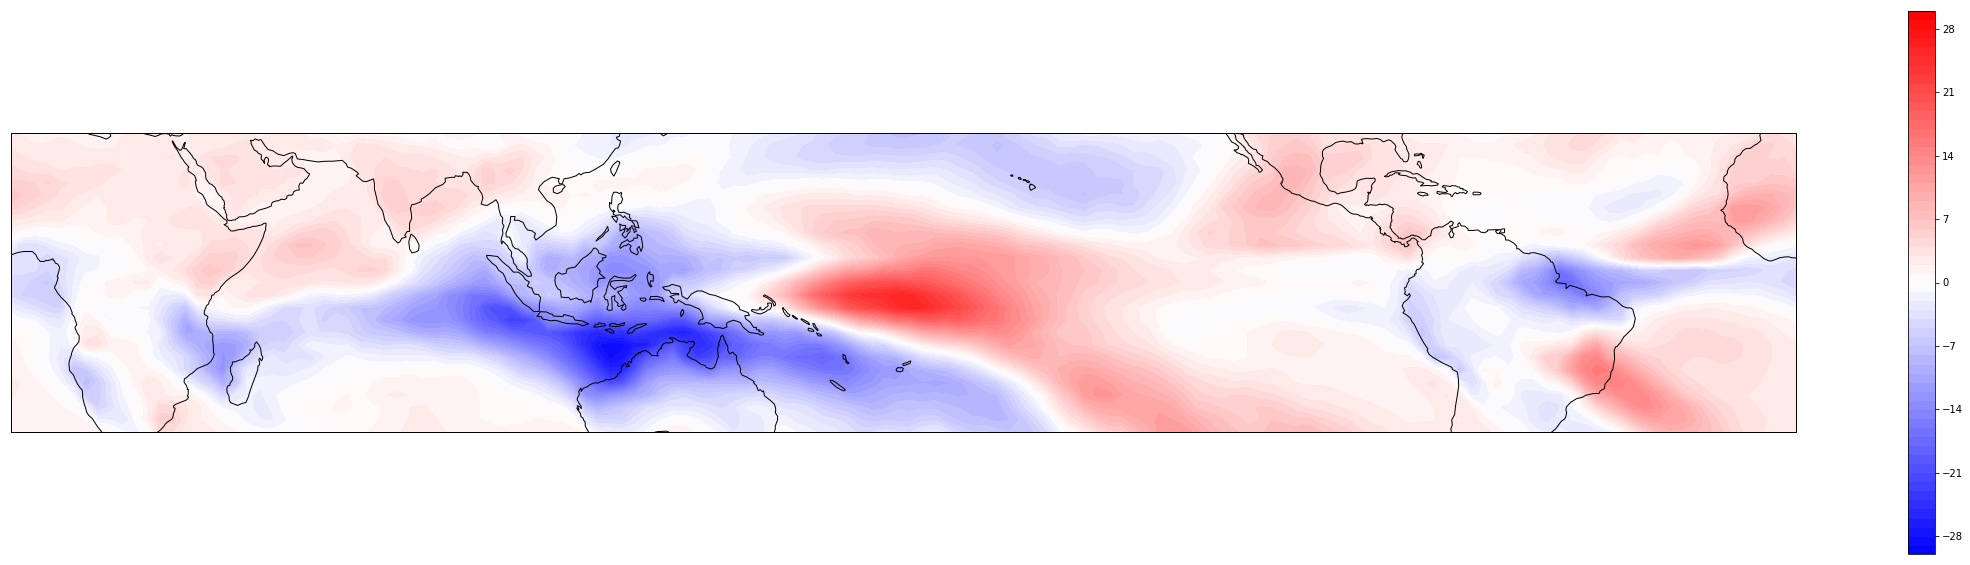

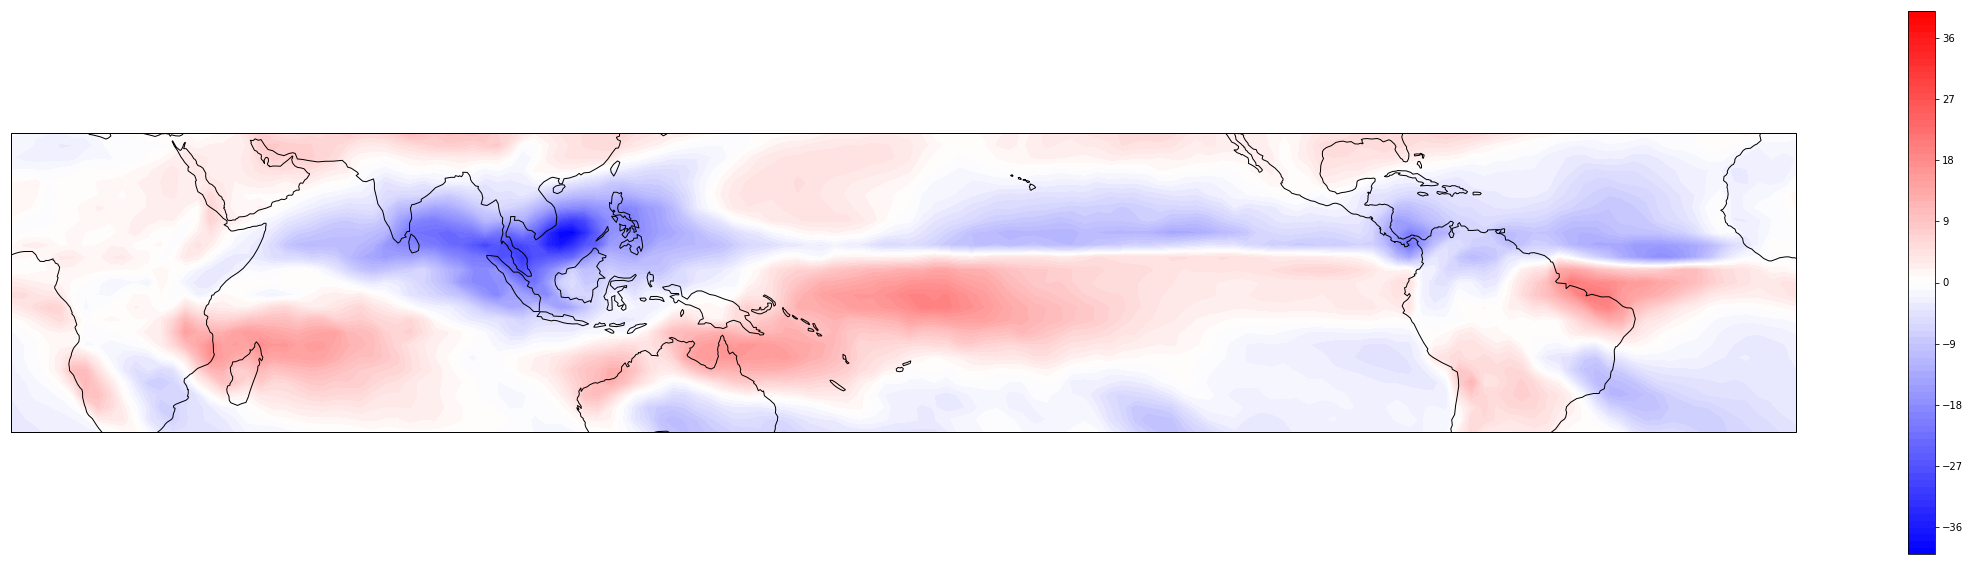

In [93]:
for i in range(number_clusters):
  mins = []
  maxes = []
  for j in all_clusters['cluster'+str(i+1)+'_composite']:
    mins.append(min(j))
    maxes.append(max(j))
  myrange = max(np.abs(min(mins)), np.abs(max(maxes)))
  levels = np.linspace(-np.ceil(myrange), np.ceil(myrange), 2*np.ceil(myrange)+1)
#   fig = plt.figure(figsize=(20*4,5*4))
  fig = plt.figure(figsize=(40,10))
  ax = plt.axes(projection=ccrs.LambertCylindrical(central_longitude=180))
  cs=ax.contourf(lon, lat, all_clusters['cluster'+str(i+1)+'_composite'][:, :],levels,
                transform=ccrs.LambertCylindrical(),
                cmap='bwr')
# cmap=plt.cm.RdYlBu_r
  ax.coastlines()
#   ax.set_extent([-90, 40, 20, 80]) # longitude latitude extent
  plt.colorbar(cs, orientation='vertical') # color map
  plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


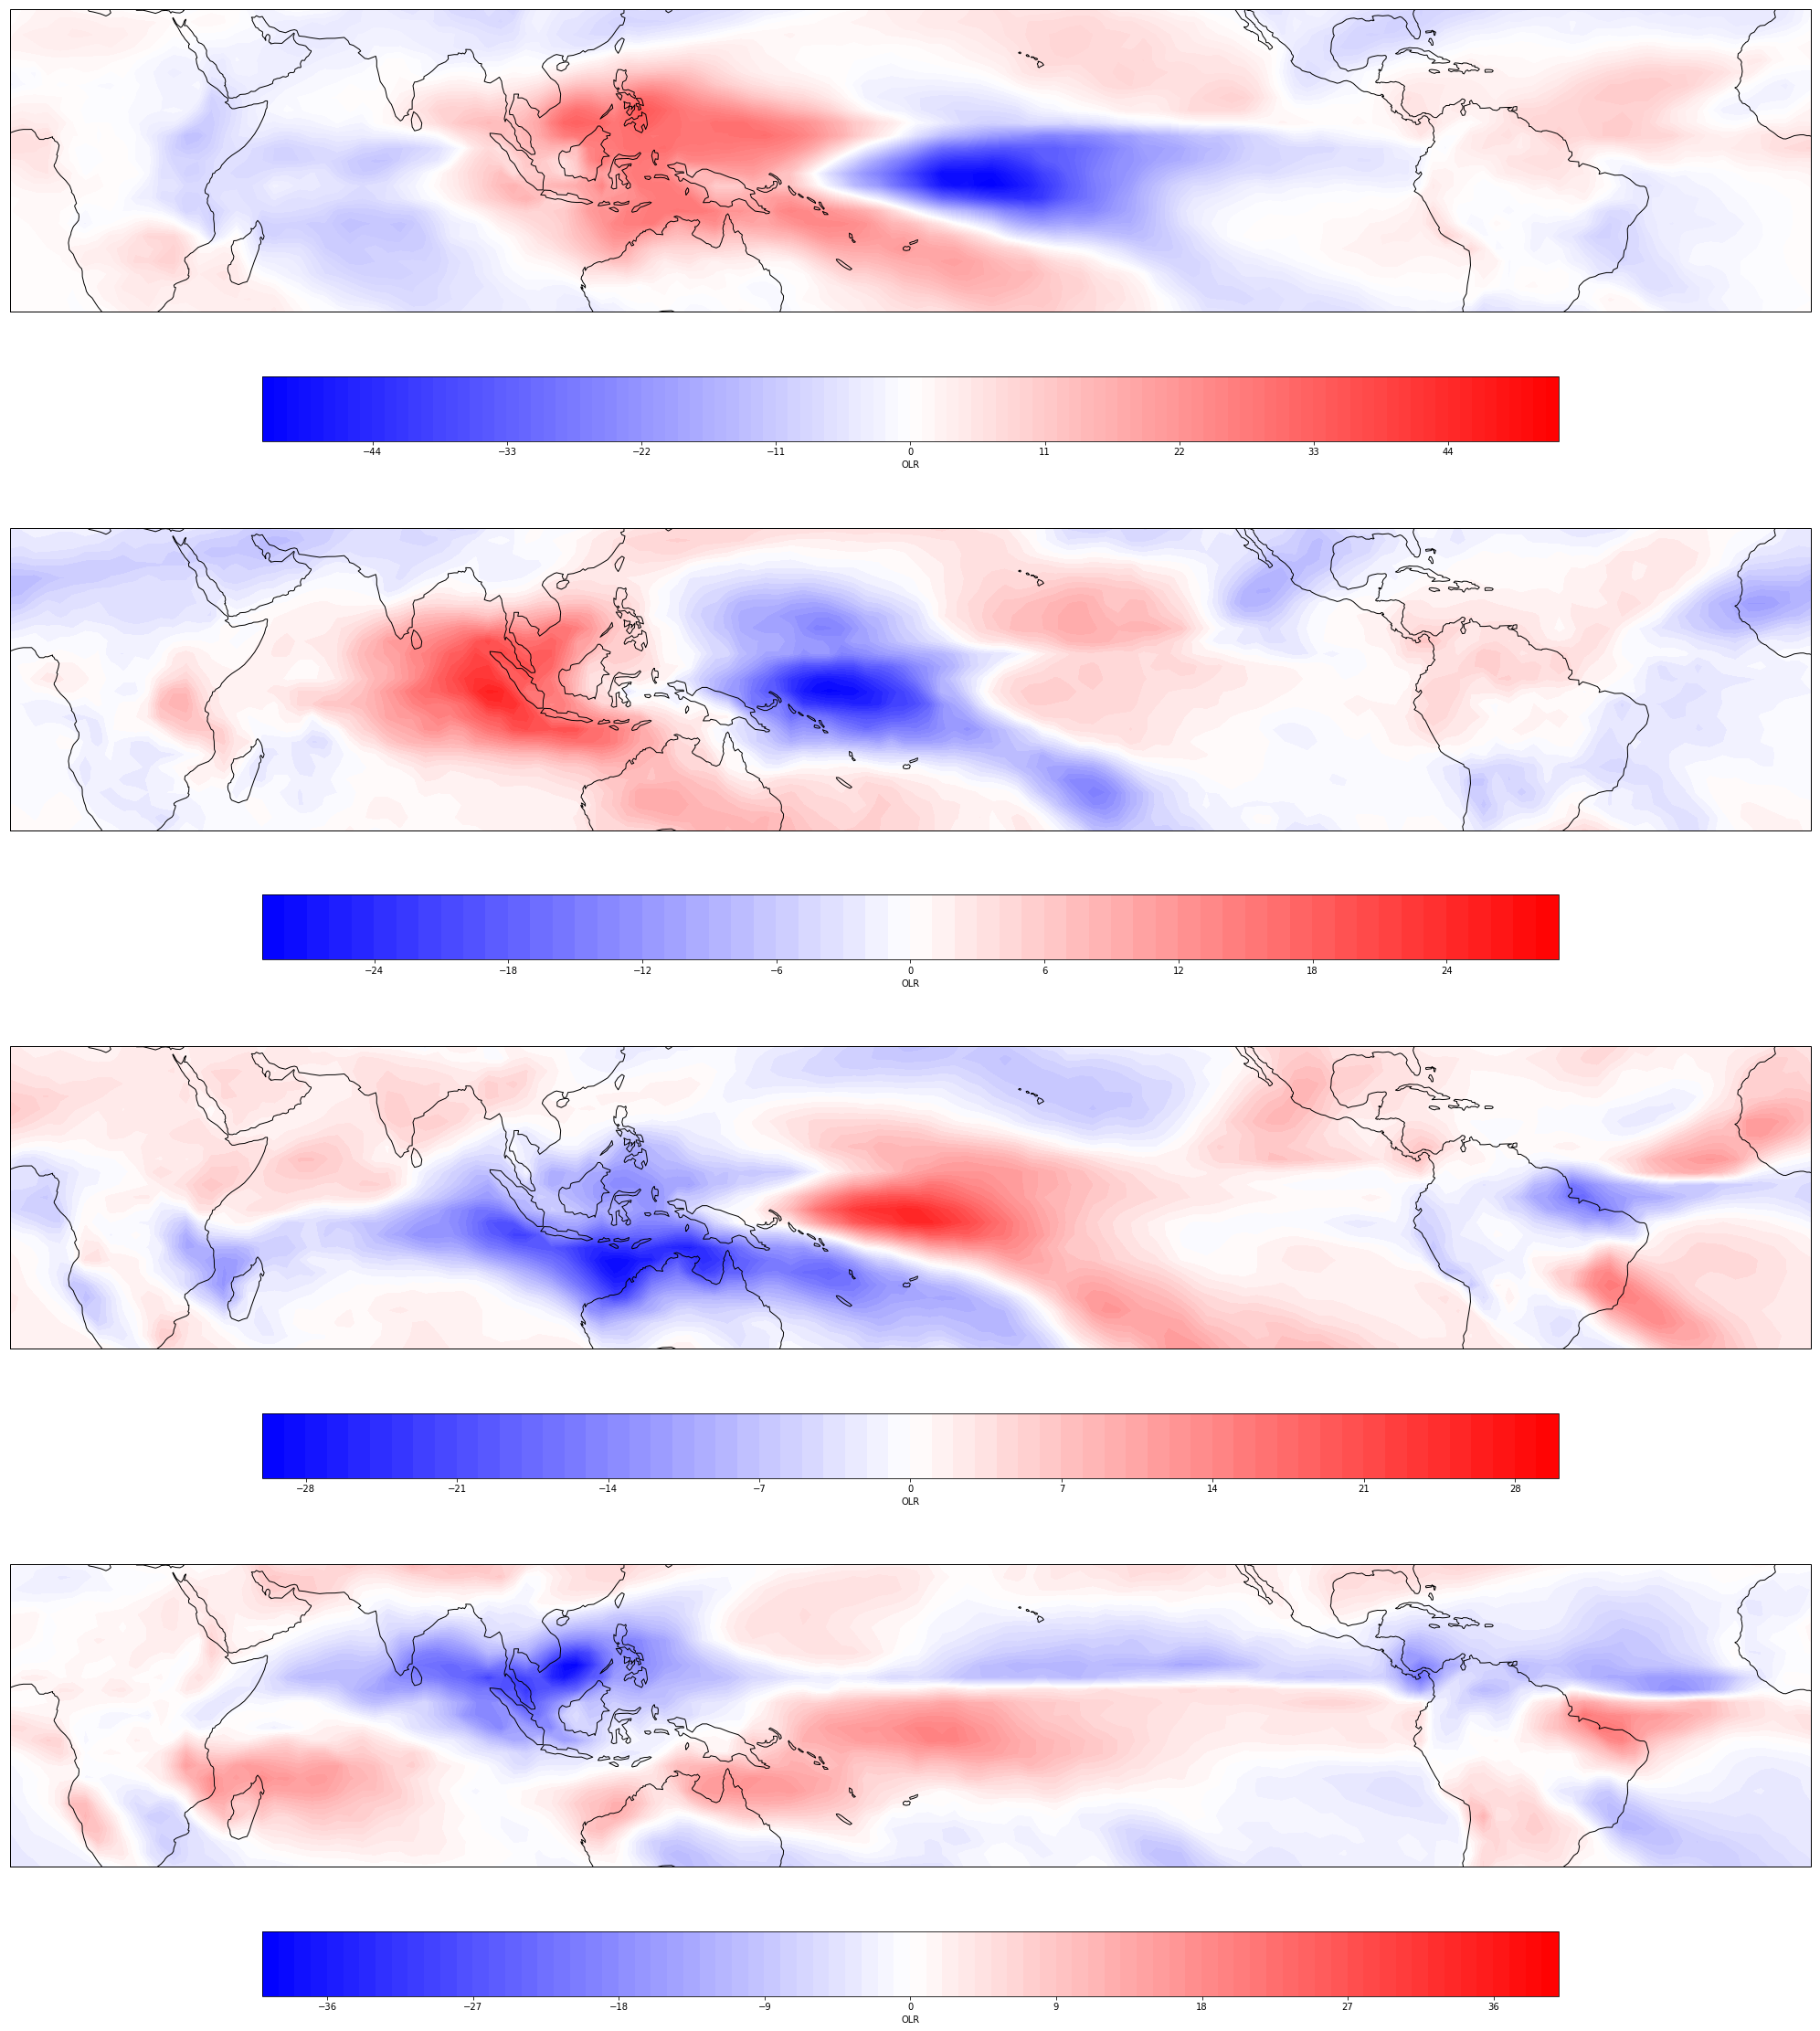

In [94]:
fig, axarr = plt.subplots(nrows=number_clusters, ncols=1, figsize=(40, number_clusters*10), subplot_kw={'projection': ccrs.LambertCylindrical(central_longitude=180)})
axlist = axarr.flatten()
for i in range(number_clusters):
  mins = []
  maxes = []
  for j in all_clusters['cluster'+str(i+1)+'_composite']:
    mins.append(min(j))
    maxes.append(max(j))
  myrange = max(np.abs(min(mins)), np.abs(max(maxes)))
  levels = np.linspace(-np.ceil(myrange), np.ceil(myrange), 2*np.ceil(myrange)+1)
#   fig = plt.figure(figsize=(20*4,5*4))
  cs=axlist[i].contourf(lon, lat, all_clusters['cluster'+str(i+1)+'_composite'][:, :],levels,
                transform=ccrs.LambertCylindrical(),
                cmap='bwr')
  axlist[i].coastlines()
#   ax.set_extent([-90, 40, 20, 80]) # longitude latitude extent
  cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal') # color map
  cbar.set_label('OLR')
#   axlist[i].colorbar(cs, orientation='vertical') # color map
plt.savefig('mjo_try'+str(number_clusters)+'_clusters.png')
plt.show()
